# IML Project
### Yanis Farhat and Benjamin Clene
#### Project conducted through pair programming

The goal of this project is to obtain a pixel classifier.

To achieve this, we have at our disposal two images: an hyperspectral image and a lidar image.

In this notebook, we will create a model and train it using a portion of the hyperspectral image and a portion of the lidar image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io

First, we will import the data to train the model.

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

lidar = data['lidar'].copy()
print("The LiDAR image is composed of %d rows and %d columns "%(lidar.shape)+"in the %s format"%lidar.dtype)
hsi_raw = data['hyper'].copy()
print("The hyperspectral image is composed of %d rows, %d columns, and %d bands "%(hsi_raw.shape)
      +"in the %s format"%hsi_raw.dtype)

The LiDAR image is composed of 349 rows and 1905 columns in the float32 format
The hyperspectral image is composed of 349 rows, 1905 columns, and 144 bands in the uint16 format


Next, we load the ground truth.

In [3]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [4]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0], dtype=int64)},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0], dtype=int64)},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87], dtype=int64)},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0], dtype=int64)},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45], dtype=int64)},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255], dtype=int64)},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255], dtype=int64)},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216], dtype=int64)},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0], dtype=int64)},
       {'class_name': 'highway', 'class_label':

We prepare the hyperspectral data before normalization to visualize the original image later.

In [5]:
def pimp_hsi(hsi_raw):
    rgb_bands = [54,32,18]
    hsi_rgb = hsi_raw[:,:,rgb_bands]
    hsi_rgb = hsi_rgb/hsi_rgb.max() # Normalization of values to [0,1] for display
    pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
    hsi_rgb_pimped = hsi_rgb.copy()
    for i in range(pmin.size):
        hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
    hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
    hsi_rgb_pimped[hsi_rgb_pimped>1] = 1
    
    return hsi_rgb_pimped

We normalize the data, achieving better results with this normalization.

In [6]:
#normalize hsi_raw
hsi_normalized = hsi_raw.astype(np.float64).copy()
for i in range (hsi_normalized.shape[0]):
    for j in range(hsi_normalized.shape[1]):
        X = hsi_normalized[i][j]
        if np.any(X != 0):
            hsi_normalized[i][j] = (X - X.min()) / (X.max() - X.min())

#normalize lidar
lidar_normalized = lidar.astype(np.float64)
lidarMin = lidar_normalized.min()
lidarMax = lidar_normalized.max()
for i in range (lidar_normalized.shape[0]):
    for j in range(lidar_normalized.shape[1]):
        X = lidar_normalized[i][j]
        if np.any(X != 0):
            lidar_normalized[i][j] = (X - lidarMin) / (lidarMax - lidarMin)

We prepare the test data by merging lidar and hyperspectral data.

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

r,c,N = hsi_normalized.shape
hsi = hsi_normalized.reshape(r*c,N)

#fusion lidar and hsi for the whole image
allData = np.concatenate((hsi, lidar_normalized.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
hsi_train = hsi_normalized[groundtruth != 0]
lidar_train = lidar_normalized[groundtruth != 0]

# fusion lidar and hsi sets
x_train = np.concatenate((hsi_train, 10*lidar_train.reshape(-1, 1)), axis=1)
y_train = groundtruth[groundtruth != 0]

#check shapes
allData.shape, hsi_train.shape, lidar_train.shape, x_train.shape, y_train.shape

((664845, 145), (2832, 144), (2832,), (2832, 145), (2832,))

We create a validation dataset from the training dataset.

In [8]:
#### from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

We train a model of type RandomForestClassifier as it achieves the best score.

The score varies depending on the data distribution by the train_test_split function.

In [40]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


classifier = RandomForestClassifier(max_depth=16, random_state=1, n_estimators=50, n_jobs=-1)
classifier = classifier.fit(x_train, y_train)
score = classifier.score(x_val, y_val)

print("score: ", score)

score:  0.9171075837742504


Finally, we predict using the model for all pixels of the image and compare it with the original image.

In [35]:
def predict(classifier, data, groundtruth_info):
    # predict for the whole image
    prediction = classifier.predict(data)
    predictionRgb = np.zeros(shape=(prediction.shape[0], 3))

    cls_rgb = []
    for ii in groundtruth_info:
        cls_rgb.append(ii['class_color'])
    cls_rgb = np.array(cls_rgb).reshape(15,-1,3)
    plt.figure(figsize=(5,5))
    plt.imshow(cls_rgb)
    plt.axis('off')
    for cls in range(15):
            plt.text(0.85,1.02*cls,'Class %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
    plt.show()

    for i in range(len(prediction)):
        predictionRgb[i] = cls_rgb[prediction[i]-1]
    predictionRgb = predictionRgb.astype(np.uint)

    plt.figure(figsize=(20,5))
    plt.title('prediction map')
    plt.imshow(predictionRgb.reshape((349,1905,3)))
    plt.show()

    plt.figure(figsize=(20,5))
    plt.imshow(pimp_hsi(hsi_raw))
    plt.show()

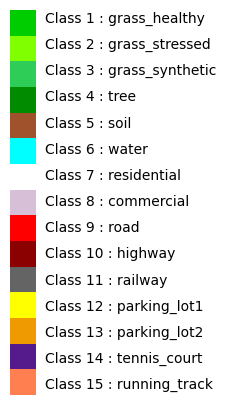

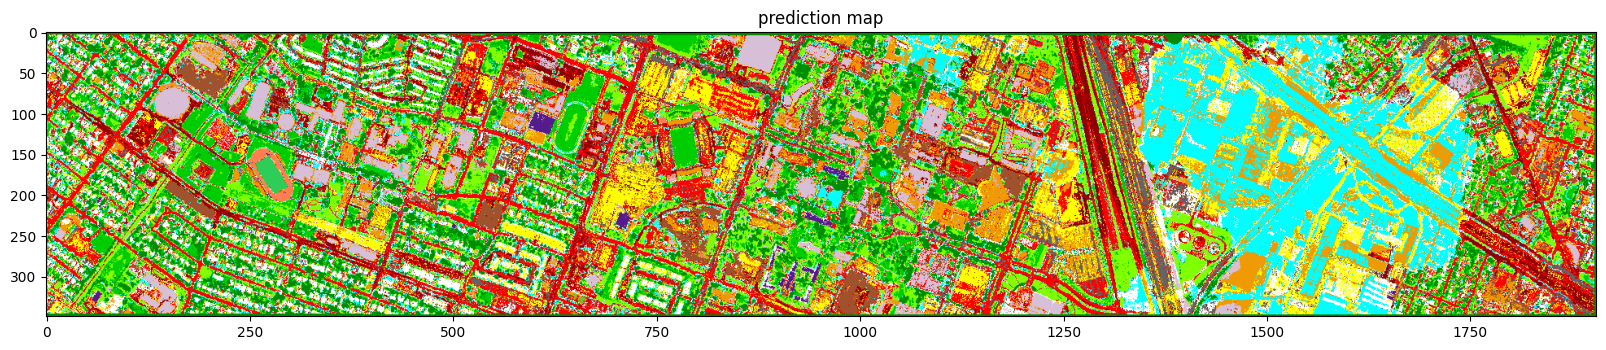

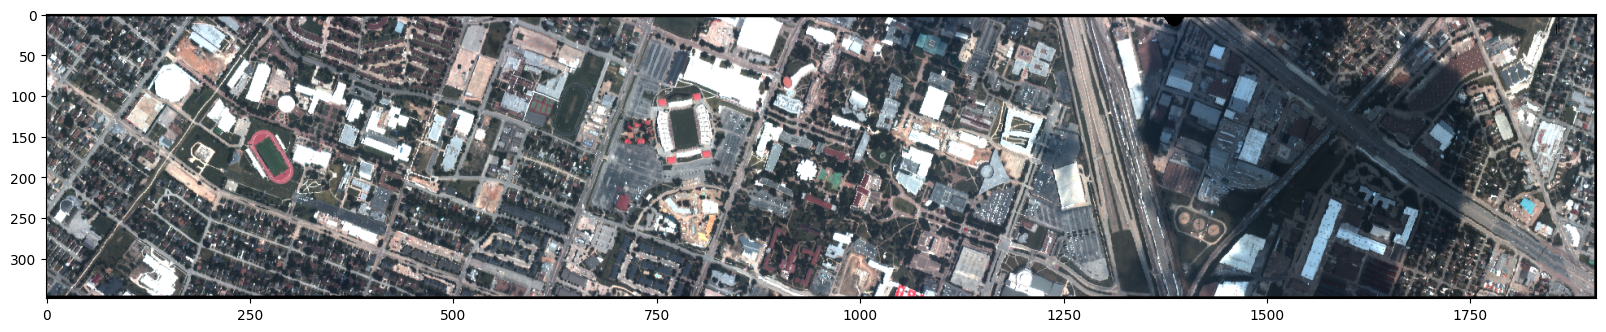

In [36]:
predict(classifier, allData, groundtruth_info)

# Cloud shadow

We can see that the cloud is heavily affecting our results and makes a portion of the image almost completely false in the predictions. The goal of this section is to get rid of this shadow.

In [11]:
from skimage import exposure, filters
from skimage.morphology import opening, closing, disk, square

def find_mask(hsi):
    
    bands = [54, 32, 18, 82, 106, 16, 1, 140, 14, 130, 128, 11, 9]
    
    #we find the thresholds for each band
    thresholds = [filters.threshold_otsu(hsi[:,:,band]) for band in bands]

    # Prendre un pourcentage du seuil d'Otsu
    thresholds = [threshold *0.9  for threshold in thresholds]
    
    # Créer un masque de nuage en combinant les seuils de toutes les bandes pertinentes
    cloud_mask = np.zeros_like(hsi[:,:,0], dtype=bool)
    for band, threshold in zip(bands, thresholds):
        cloud_mask |= (hsi[:,:,band] > threshold)
    
    return cloud_mask

In [12]:
def salt_pepper_filter_with_morphology(mask, salt_pepper_strength=60, opening_size=15, closing_size=25):
    # Appliquer le filtre médian pour réduire le bruit sel et poivre
    filtered_mask = filters.median(mask, footprint=square(salt_pepper_strength))

    for i in range(3):
        # Appliquer l'ouverture pour supprimer le bruit blanc et les petits objets
        filtered_mask = opening(filtered_mask, footprint=disk(opening_size))
        # Appliquer la fermeture pour combler les petits trous dans les objets
        filtered_mask = closing(filtered_mask, footprint=disk(closing_size))

    return filtered_mask

In [13]:
def min_max_scale_array(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

In [20]:
def remove_shadow(hsi, shadow_mask):
    hsi_shadow = hsi.copy()
    for band in range(hsi.shape[2]):
        hsi_normalized = min_max_scale_array(hsi_shadow[:, :, band])
           
        hsi_shadow[:, :, band][~shadow_mask] = exposure.equalize_hist(hsi_normalized[~shadow_mask])*np.amax(hsi_normalized)
        hsi_shadow[:, :, band][shadow_mask] = exposure.equalize_hist(hsi_normalized[shadow_mask])*np.amax(hsi_normalized)

        
    return hsi_shadow

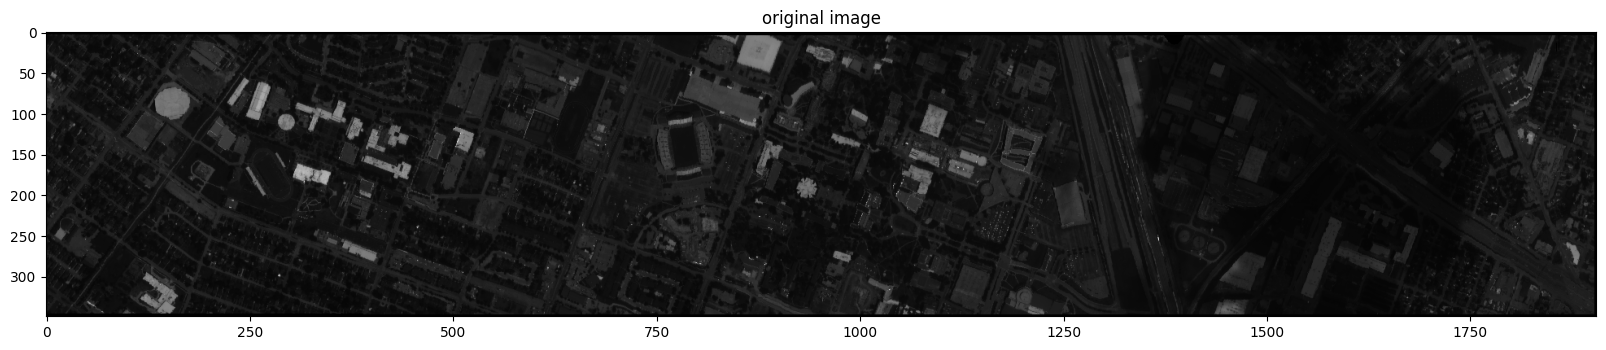

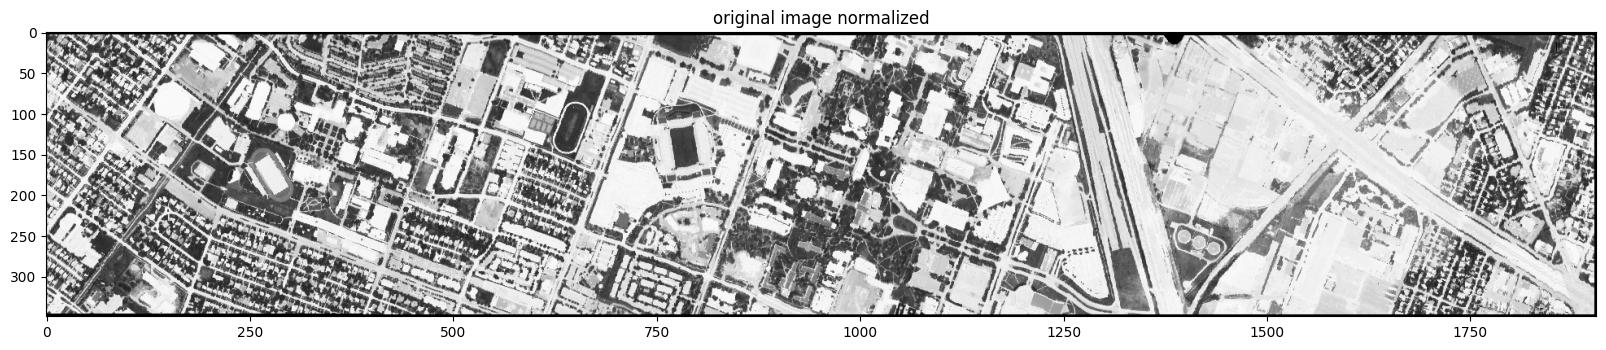

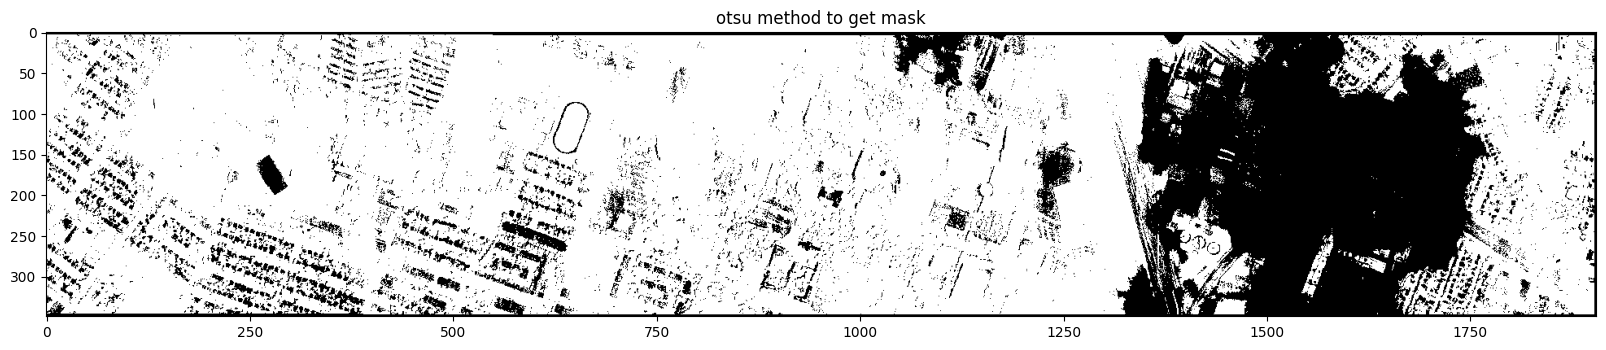

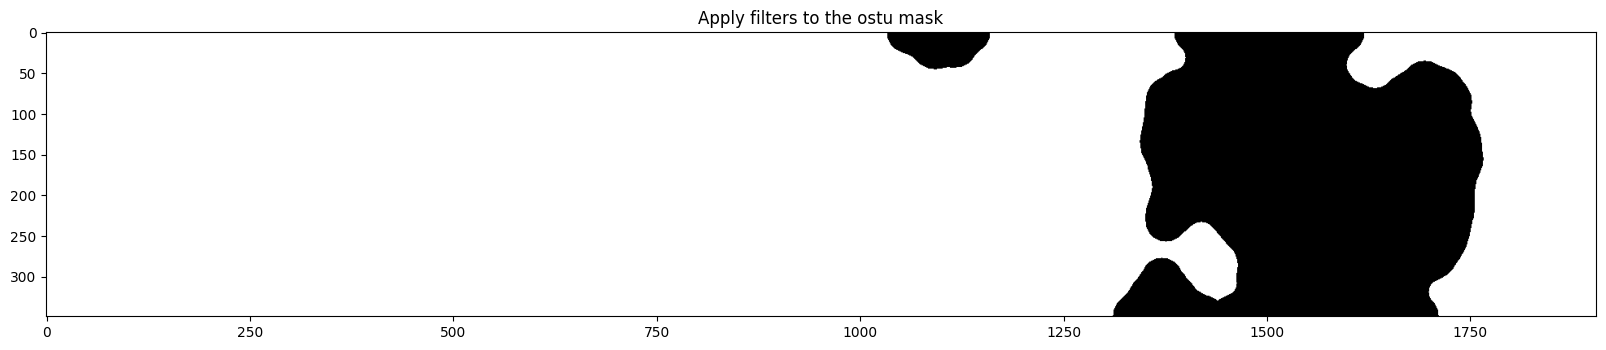

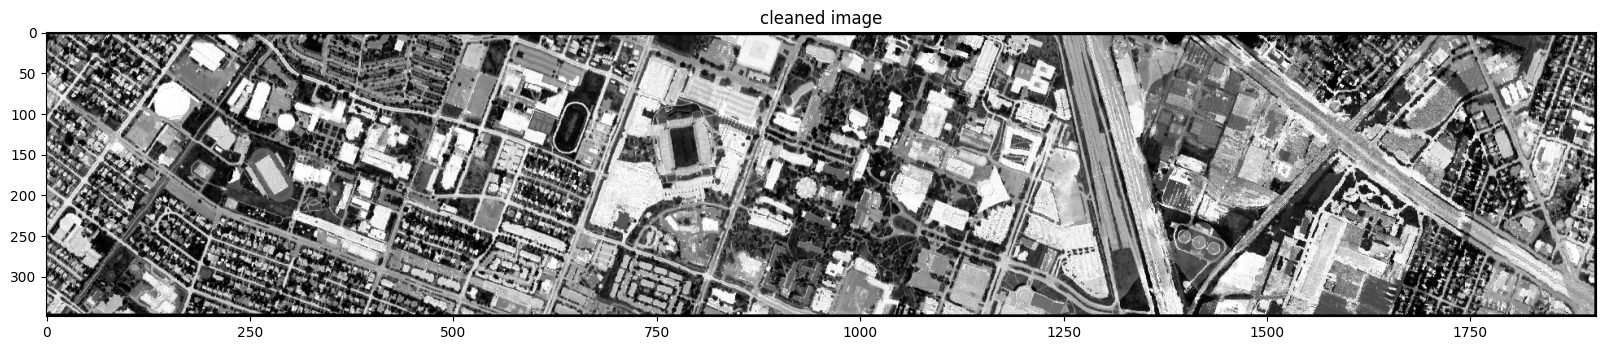

In [34]:
band = 32
original = hsi_raw
original_normalized = hsi_normalized
mask = find_mask(hsi_raw)
cleaned_mask = salt_pepper_filter_with_morphology(mask)
cleaned_original = remove_shadow(hsi_normalized, cleaned_mask)

plt.figure(figsize=(20,5))
plt.imshow(original[:,:,band], cmap='gray')
plt.title('original image')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(original_normalized[:,:,band], cmap='gray')
plt.title('original image normalized')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(mask, cmap='gray')
plt.title('otsu method to get mask')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Apply filters to the ostu mask')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(cleaned_original[:,:,band], cmap='gray')
plt.title('cleaned image')
plt.show()

Now we can do a prediction on this cleaned image

In [38]:
cleaned_original.shape

(349, 1905, 144)

In [41]:
r,c,N = cleaned_original.shape
hsi_cleaned = cleaned_original.reshape(r*c,N)

newAllData = np.concatenate((hsi_cleaned, lidar_normalized.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
new_hsi_train = cleaned_original[groundtruth != 0]
new_lidar_train = lidar_normalized[groundtruth != 0]

# fusion lidar and hsi sets
new_x_train = np.concatenate((new_hsi_train, 10*new_lidar_train.reshape(-1, 1)), axis=1)
new_y_train = groundtruth[groundtruth != 0]

#check shapes
newAllData.shape, new_hsi_train.shape, new_lidar_train.shape, new_x_train.shape, new_y_train.shape

((664845, 145), (2832, 144), (2832,), (2832, 145), (2832,))

In [68]:
new_x_train, new_x_val, new_y_train, new_y_val = train_test_split(new_x_train, new_y_train, test_size=0.2, stratify=new_y_train)

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming new_x_train, new_y_train, x_val, and y_val are already defined

# Define a dictionary of classifiers with potential hyperparameters
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1),
    'SVM': SVC(),
    #'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier()
}

# Define hyperparameters to test for each classifier
param_grid = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    #'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
}

# Iterate over classifiers and perform grid search with cross-validation
for clf_name, clf in classifiers.items():
    # If hyperparameters are specified, perform GridSearchCV
    if clf_name in param_grid:
        grid_search = GridSearchCV(clf, param_grid[clf_name], cv=3, scoring='accuracy')
        grid_search.fit(new_x_train, new_y_train)
        best_clf = grid_search.best_estimator_
    else:
        best_clf = clf
    
    # Train the best classifier
    best_clf.fit(new_x_train, new_y_train)
    
    # Make predictions on the validation set
    y_pred = best_clf.predict(new_x_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(new_y_val, y_pred)
    
    # Print the results
    print(f"{clf_name} - Best Accuracy: {accuracy:.4f}")
    if clf_name in param_grid:
        print(f"Best Hyperparameters: {grid_search.best_params_}")
    print("\n")


Random Forest - Best Accuracy: 0.9418
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 200}


SVM - Best Accuracy: 0.9347
Best Hyperparameters: {'C': 10, 'kernel': 'linear'}


K-Nearest Neighbors - Best Accuracy: 0.9189
Best Hyperparameters: {'n_neighbors': 3}


Decision Tree - Best Accuracy: 0.8519
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5}




In [74]:
newClassifier = RandomForestClassifier(max_depth=20, n_estimators=200, random_state=1, n_jobs=-1)
newClassifier = newClassifier.fit(new_x_train, new_y_train)

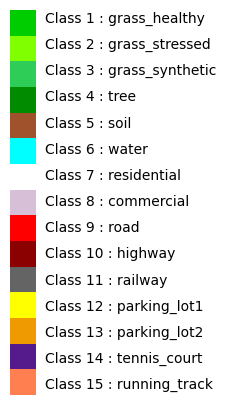

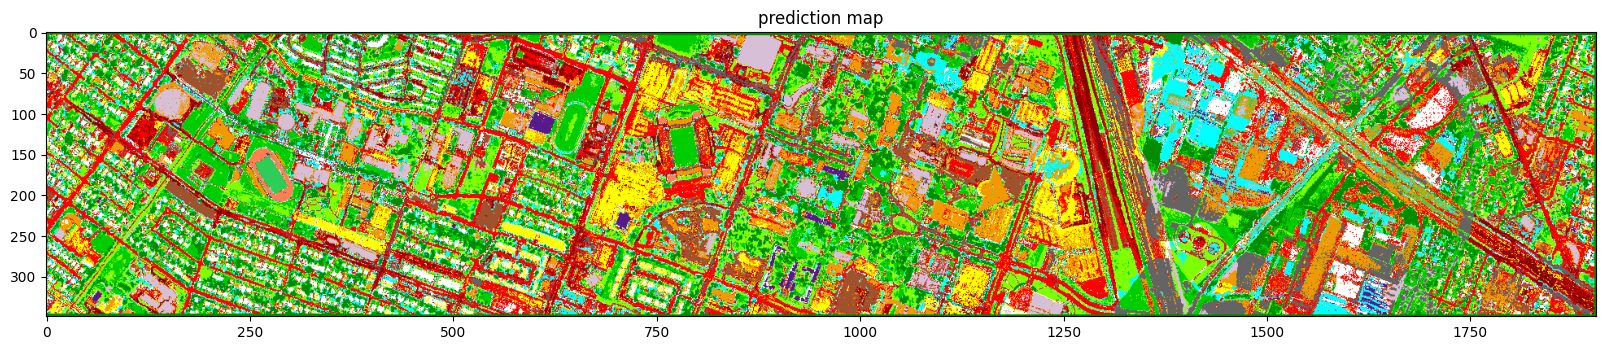

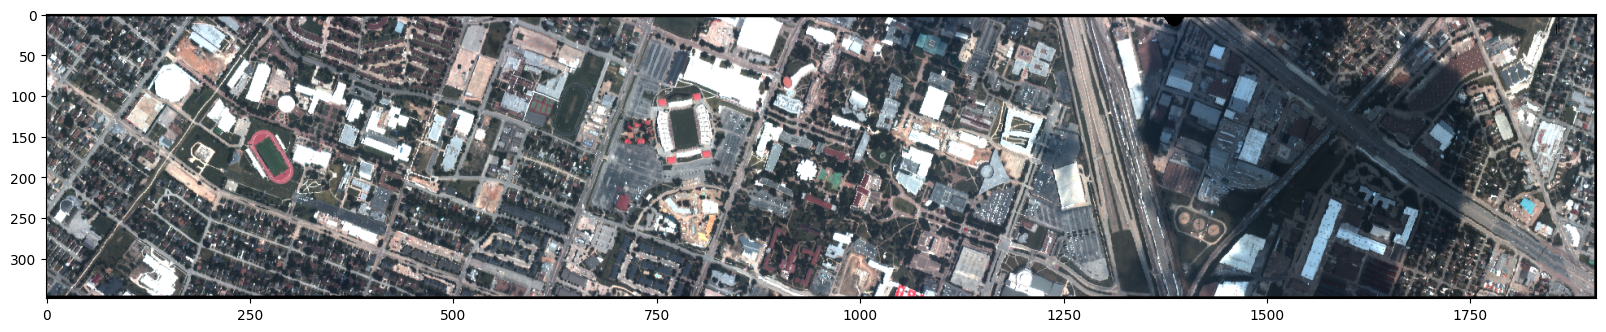

In [75]:

predict(newClassifier, newAllData, groundtruth_info)